In [ ]:
!pip install datasets --quiet
!pip install transformers datasets evaluate --quiet
!pip install nltk --quiet
!pip install transformers --quiet

!pip install -q spacy
!pip install -q medspacy # https://github.com/medspacy/medspacy
!pip install -q spacy-lookups-data
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from datasets import list_datasets, load_dataset

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from transformers import AutoTokenizer, TFAutoModel
from transformers import TFAutoModelForSequenceClassification
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import evaluate
import os
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.data import find
from nltk.corpus import stopwords
nltk.download('stopwords')

nltk.download('punkt')

import re
import torch
import spacy
import medspacy
import torch.nn.functional as F
from sklearn import metrics
from tqdm.auto import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ade_corpus_v2",'Ade_corpus_v2_classification')

Generating train split:   0%|          | 0/23516 [00:00<?, ? examples/s]

Dataset ade_corpus_v2 downloaded and prepared to /root/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0/940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 23516
    })
})


### Preprocessing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=250)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/23516 [00:00<?, ? examples/s]

In [ ]:
#train_test split
split_data_set = tokenized_datasets["train"].train_test_split(test_size=0.2, train_size=0.8)

In [ ]:
split_data_set

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18812
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4704
    })
})

### Modeling

In [ ]:
model_checkpoint = "dmis-lab/biobert-base-cased-v1.2"
batch_size = 16

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=2)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
args = TrainingArguments(
    output_dir="results",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_strategy = "epoch"

)

In [ ]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
train_dataset = split_data_set["train"].shuffle(seed=42)
eval_dataset = split_data_set["test"].shuffle(seed=42)

In [ ]:
#use Trainer class to train bioBert model 
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.185900,0.163351,0.949405
2,0.108400,0.175660,0.956207
3,0.061800,0.200865,0.957058
4,0.028500,0.237901,0.958971
5,0.011900,0.261610,0.960034


TrainOutput(global_step=5880, training_loss=0.0843175356079932, metrics={'train_runtime': 4484.8801, 'train_samples_per_second': 20.973, 'train_steps_per_second': 1.311, 'total_flos': 1.20840946617e+16, 'train_loss': 0.0843175356079932, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.1633514165878296,
 'eval_accuracy': 0.9494047619047619,
 'eval_runtime': 75.2706,
 'eval_samples_per_second': 62.495,
 'eval_steps_per_second': 3.906,
 'epoch': 5.0}

In [ ]:
model_trained = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-5880").to("cuda")

In [ ]:
#apply model to test dataset
progress_bar = tqdm(range(len(eval_dataset['text'])))
y_preds = []
y_trues = []
for index,val_text in enumerate(eval_dataset['text']):
     encoding = tokenizer([val_text], 
                          truncation=True, padding="max_length", max_length=250, return_tensors="pt")
     encoding = {k: v.to(trainer.args.device) for k, v in encoding.items()}
     with torch.no_grad():
       outputs = trainer.model(**encoding)
     logits = outputs.logits 
     prediction = logits.argmax(-1).cpu().numpy()[0]
     y_true = eval_dataset['label'][index]
     y_preds.append(prediction)
     y_trues.append(y_true)
     progress_bar.update(1)

  0%|          | 0/4704 [00:00<?, ?it/s]

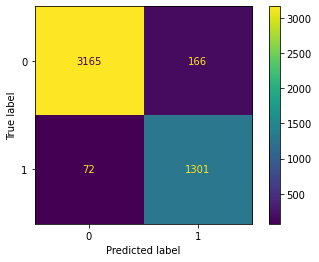

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3331
           1       0.89      0.95      0.92      1373

    accuracy                           0.95      4704
   macro avg       0.93      0.95      0.94      4704
weighted avg       0.95      0.95      0.95      4704



In [ ]:
cm = confusion_matrix(y_trues, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_trues, y_preds))